In [1]:
import import_ipynb

from IPython.display import display, Image, HTML, update_display
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Dense
from threading import Thread, Lock
from keras.models import Model
import tensorflow as tf
import numpy as np
import datetime
import dataset
import tools
import users
import time
import uuid
import ads
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
root_directories = ["ADS16_Benchmark_part1", "ADS16_Benchmark_part2"]

In [3]:
def load_user_and_ad_ftrs(root_directories, try_load_files=True, save_files=True):
    ad_ftrs_path = os.path.join("data", "ad_ftrs.npz")
    user_ftrs_and_ratings_path = os.path.join("data", "user_ftrs_and_ratings.npz")

    if try_load_files and os.path.exists(ad_ftrs_path):
        with np.load(ad_ftrs_path) as ad_ftrs_file:
            ad_ftrs = ad_ftrs_file["ftrs"]
            num_categories = int(ad_ftrs_file["num_categories"])
    else:
        ad_ftrs, num_categories = ads.load_ftrs(root_directories)
        if save_files:
            np.savez(ad_ftrs_path, ftrs=ad_ftrs, num_categories=num_categories)
    
    if try_load_files and os.path.exists(user_ftrs_and_ratings_path):
        with np.load(user_ftrs_and_ratings_path) as user_ftrs_and_ratings:
            user_ftrs = user_ftrs_and_ratings["user_ftrs"]
            ratings = user_ftrs_and_ratings["ratings"]
    else:
        raw_user_ftrs, ratings = users.load_raw_ftrs(root_directories)
        *_, user_ftrs = users.calculate_pca_ftrs(raw_user_ftrs)
        if save_files:
            np.savez(user_ftrs_and_ratings_path, user_ftrs=user_ftrs, ratings=ratings)
    
    return ad_ftrs, num_categories, user_ftrs, ratings

if __name__ == "__main__":
    ad_ftrs, num_categories, user_ftrs, ratings = load_user_and_ad_ftrs(root_directories)

In [4]:
if __name__ == "__main__":
    X = tools.ftr_cartesian_product(user_ftrs, ad_ftrs)
    ratings_normalizer = StandardScaler()
    Y = ratings_normalizer.fit_transform(ratings.flatten()[:, np.newaxis])[:,0]
    print(X.shape)
    print(Y.shape)

(36000, 553)
(36000,)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 553)]             0         
                                                                 
 dense (Dense)               (None, 16)                8864      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 9,153
Trainable params: 9,153
Non-trainable params: 0
_________________________________________________________________


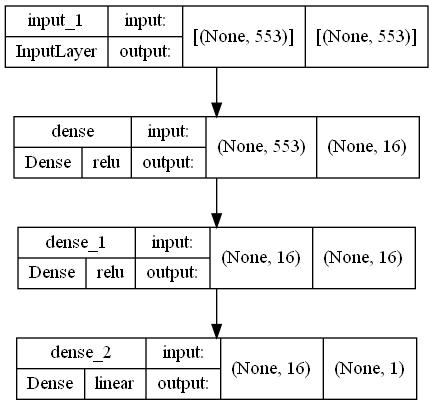

In [5]:
def std_dev_pct_error(y_true, y_pred):
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    return (std_pred - std_true)/std_pred if std_pred > 0 else tf.constant(np.nan)

def for_ratings(normalizer):
    def aux(func):
        def inner(y_true, y_pred):
            return func(
                normalizer.scale_ * y_true + normalizer.mean_,
                normalizer.scale_ * y_pred + normalizer.mean_
            )
        inner.__name__ = f"{func.__name__}_for_ratings"
        return inner
    return aux

def create_model():
    ad_ftrs, _, user_ftrs, _ = load_user_and_ad_ftrs(root_directories)

    inputs = Input((user_ftrs.shape[1]+ad_ftrs.shape[1]))
    output = inputs
    output = Dense(16, activation="relu", kernel_regularizer="l2")(output)
    output = Dense(16, activation="relu", kernel_regularizer="l2")(output)
    output = Dense(1, kernel_regularizer="l2")(output)

    model = Model(inputs=[inputs], outputs=[output])
    return model

if __name__ == "__main__":
    model = create_model()
    model.compile(optimizer="adam", loss="mae", metrics=[for_ratings(ratings_normalizer)(tf.keras.losses.mean_absolute_error), std_dev_pct_error])
    model.summary()
    model_plot_filename = "user_ad_interaction_model.png"
    plot_model(model, to_file=model_plot_filename, show_shapes=True, show_layer_activations=True)
    display(Image(model_plot_filename))
    

In [6]:
def plot_distributions(title):
    rows = num_categories
    cols = 3

    fig = plt.figure(constrained_layout=True, figsize=(cols*8, rows*6))
    fig.suptitle(title, fontsize=20)
    fig.patch.set_facecolor("white")
    
    subfigs = fig.subfigures(rows, 1)

    bins = bins=np.arange(1,5+2,1) - 0.5
    bin_centers = 0.5*(bins[1:]+bins[:-1])

    pred = ratings_normalizer.inverse_transform(model.predict(X))

    user_ftr_params = users.approximate_normal_params(user_ftrs.T)
    sim_user_ftrs = users.generate_synthetic_pca_ftrs(user_ftrs.shape[0], user_ftr_params)
    
    sim_pred = ratings_normalizer.inverse_transform(model.predict(tools.ftr_cartesian_product(sim_user_ftrs, ad_ftrs)))

    for cat, subfig in enumerate(subfigs):
        subfig.suptitle(f"Category {cat}", fontsize=16)

        axs = subfig.subplots(1, cols)

        for col, ax in enumerate(axs):
            ax.plot()
            ax.set_xlabel(f"Rating")
            ax.set_ylabel(f"Probability Density")
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        cat_mask = ad_ftrs[:,cat] == 1
        real_cat_ratings = ratings[:,cat_mask]
        pred_cat_ratings = pred.reshape(ratings.shape)[:,cat_mask]
        sim_cat_ratings = sim_pred.reshape(ratings.shape)[:,cat_mask]

        i = 0

        axs[i].set_title(f"Ground Truth")
        for user in real_cat_ratings:
            heights, _ = np.histogram(user, bins=bins, density=True)
            axs[i].plot(bin_centers, heights, c="blue", alpha=0.1)
        i += 1
        
        axs[i].set_title(f"Predicted (Real Users)")
        for user in pred_cat_ratings:
            heights, _ = np.histogram(user, bins=bins, density=True)
            axs[i].plot(bin_centers, heights, c="red", alpha=0.1)
        i += 1
        
        axs[i].set_title(f"Predicted (Simulated Users)")
        for user in pred_cat_ratings:
            heights, _ = np.histogram(user, bins=bins, density=True)
            axs[i].plot(bin_centers, heights, c="green", alpha=0.1)
        i += 1
    
    plt.close()
    return fig

# if __name__ == "__main__":
#     display(plot_distributions("Rating Distributions"))


In [7]:
class DisplayableCallback(Callback):
    def __init__(self, name):
        super().__init__()
        self.name = name
        self.display_id = f"{self.name}-{str(uuid.uuid1())}"
    
    def create_display(self):
        display(HTML(self.name), display_id=self.display_id)
    
    def update_display(self, obj):
        update_display(obj, display_id=self.display_id)

class Printer(DisplayableCallback):
    def __init__(self):
        super().__init__("Epoch Data")
        self.epoch = -1

    def on_epoch_end(self, epoch, logs=None):
        header = f"Epoch {epoch}"
        lines = []
        self.epoch = epoch
        if logs is not None:
            for k, v in logs.items():
                lines.append(f"{k}={v:.5f}")
        self.update_display(HTML(f"<h3>{header}</h3>"+"<br/>".join(lines)))
    

class DistributionPlotter(DisplayableCallback):
    def __init__(self):
        super().__init__("Rating Distributions")
        self.lock = Lock()
    
    def on_epoch_end_(self, epoch, logs=None):
        with self.lock:
            self.update_display(plot_distributions(f"Rating Distributions: Epoch {epoch}"))

    def on_epoch_end(self, epoch, logs=None):
        if not self.lock.locked():
            Thread(target=self.on_epoch_end_, args=(epoch, logs)).start()
            

if __name__ == "__main__":
    checkpoints_dir="user_ad_interaction_model_checkpoints"
    filepath = os.path.join(checkpoints_dir, "model-{epoch:06d}-{val_loss:06f}.hdf5")
    checkpoint = ModelCheckpoint(filepath, monitor=["val_loss"], save_weights_only=True, verbose=0, save_best_only=False, mode="min")

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    printer = Printer()
    plotter = DistributionPlotter()

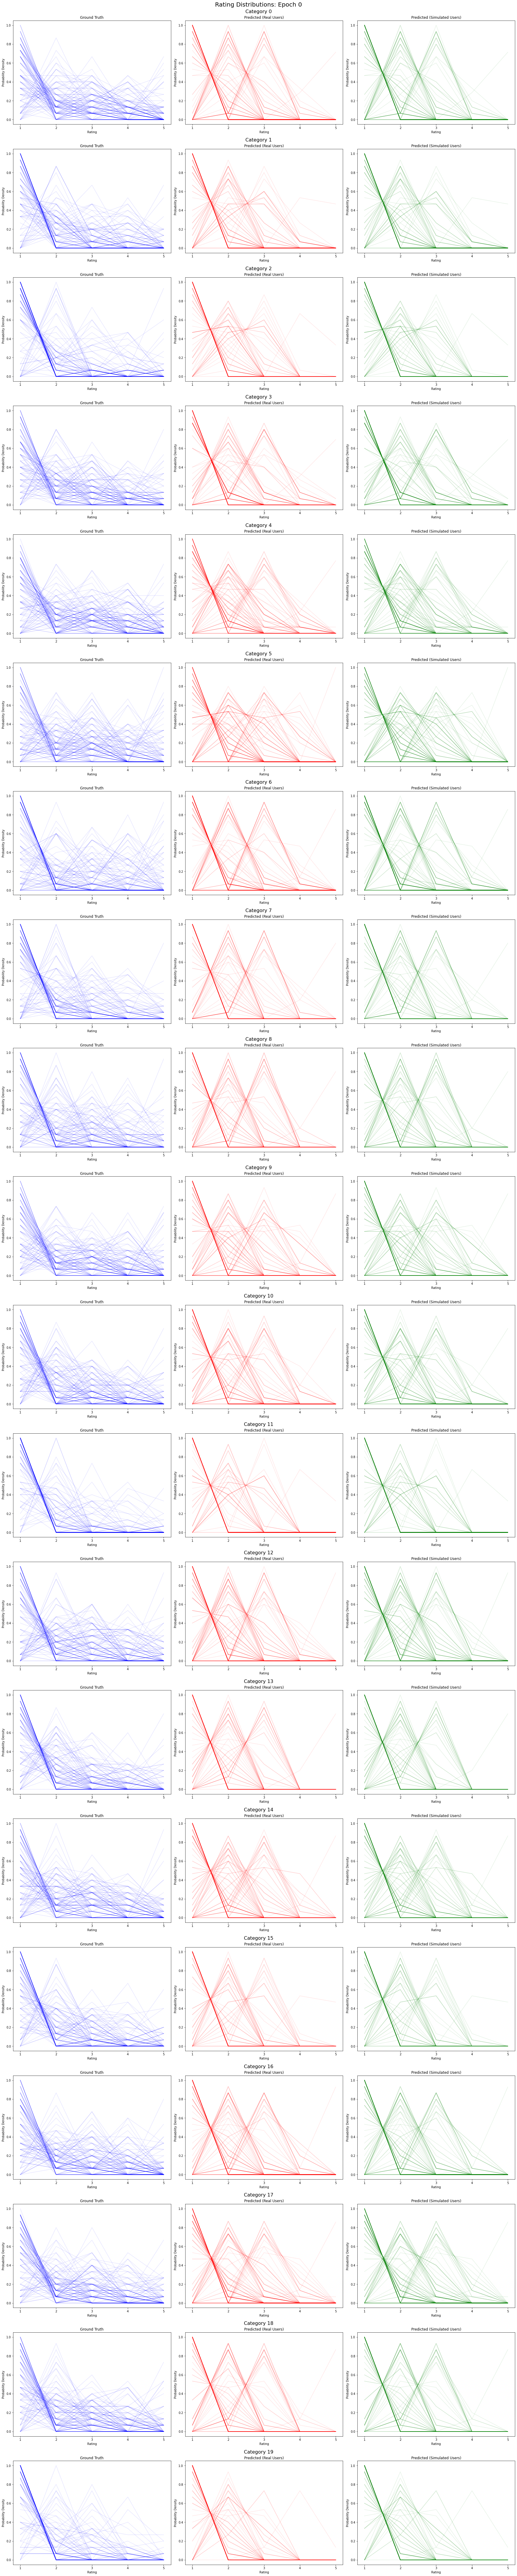

In [8]:
if __name__ == "__main__":
    batch_size = 32
    epochs = 1000

    if not os.path.isdir(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    printer.create_display()
    plotter.create_display()

    try:
        model.fit(
            X,
            Y,
            batch_size=batch_size,
            initial_epoch = printer.epoch+1,
            verbose=0,
            shuffle=True,
            validation_split=0.2,
            epochs=epochs,
            callbacks=[tensorboard_callback, checkpoint, printer, plotter]
        )
    except KeyboardInterrupt:
        pass